<link rel="stylesheet" href="../style.css">
<section id="blog-navigation">
    <a class="link-previous-blog-post" >
        <div class="arrow-left"></div>
        <s>Previous blog post</s>
    </a>
    <a href=".." class="link-to-blog-entries">
        <div class="arrow-up"></div>
        <p>Back to blog list</p>
    </a>
    <a class="link-next-blog-post" diabled>
        <div class="arrow-right"></div>
        <s>Next blog post</s>
    </a>
</section>

# Elevator Queuing Simulation

Elevators are an interesting bunch. You enter a closet, doors are shut and you are disconnected from outside word for a fleeting moment. Next thing you know you are transported somewhere else in this world. For all we know, you might end up in an alternate universe, who can tell. But one thing is for certain though, nobody likes waiting long times in the hall for elevator to come and pick them up. Even worse being stuck inside the elevator for long with strangers in awkward silence, compounded by the fact that they are [Faraday cage](https://en.wikipedia.org/wiki/Faraday_cage) (no cat videos to go through 🥹). All in all, best elevators are those you spend least time with. 

This brings up a curious problem, how does elevator decide which floor to go next. Do you make sure you finish your current passengers transport first? When you're on 8th floor with people going to 15th floor and person calls elevator on 7th floor, should you change direction and pick them and then continue the journey? What if two people call you up, one 5 floors up and another 5 floors down? Do you give priority to the person who called elevator first? If there are multiple elevators which one should pick up the call, the one already heading to the destination, or the one closest to it? Would it all be better if elevator knew in advance where people are going?

Inspired by these questions and little bit of frustration from my personal experience I decided to see what I can learn about the problem. It seems some sort of min-max problem - how to serve maximum number of people by minimum amount of movement. Let's see what we can learn by coding a primitive simulation and testing things. 

In [7]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

## Simulation setup

Simulation is as follows - there will be a building with `n` floors and 1 elevator (for start). Simulation will go on for `N` timesteps at every timestep, random people will appear that desire to go to specific floor. Elevator will do its thing. At the end of simulation I will calculate `average waiting time` - average number of time it took for people to arrive at their destination. I ended up creating three classes.

- `Person` : simply holds where it wants to go and timestep it appeared
- `Elevator` : has certain capacity (maximum people it can hold), its current floor, direction it is heading (up or down) and list of `Person`s currently on it
- `Building` : `num_floors` stores total number of floors in the building, an `Elevator` object and a `lounge` - information about people currently waiting for an elevator which is a list of length `num_floors` and each entry is a list of `Person`s. Then there is a `step` function which defines a single simulation step

To start with, I consider a very simple (certainly unrealistic) elevator movement protocol - it moves up until it reaches the top floor, then changes its direction till the ground floor and so on. On every floor, passengers who are at their desired floor leave and if there a people on the lounge they hop on the elevator. 

Additionally I have written a function to generate string representation of the building that can be used to test things work as expected. The code is as follows.

In [8]:
UP, DOWN = 1, -1

class Person: 

    def __init__(self, target_floor, spawn_timepoint) -> None:
        self.target_floor = target_floor
        self.spawn_timepoint = spawn_timepoint

class Elevator:

    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self.people = []
        self.current_floor = 1
        self.current_direction = UP
    
class Building:

    def __init__(self, num_floors) -> None:
        self.num_floors = num_floors
        self.lounge = []
        for _ in range(num_floors):
            self.lounge.append([])
        self.elevator : Elevator = Elevator(5)
    
    def step(self):
        unloaded_people = [p for p in self.elevator.people if p.target_floor == self.elevator.current_floor]
        self.elevator.people = [p for p in self.elevator.people if p.target_floor != self.elevator.current_floor]
        while len(self.elevator.people)<self.elevator.capacity:
            try:
                self.elevator.people.append(self.lounge[self.elevator.current_floor-1].pop())
            except IndexError:
                break
        self.elevator.current_floor += self.elevator.current_direction
        if self.elevator.current_floor in [1, self.num_floors]:
            self.elevator.current_direction *= -1
        return unloaded_people

    def add_person(self, p :Person, floor):
        self.lounge[floor-1].append(p)

    def __str__(self) -> str:
        reprr=""
        for i, l in enumerate(self.lounge[::-1]):
            t = (self.num_floors-i)==self.elevator.current_floor
            reprr+= ("<" if t else "|" ) + str(self.num_floors-i) + (">" if t else "|" ) + "o "*len(l) + "\n"
        reprr += f"people on elevator: {len(self.elevator.people)}\n"

        return reprr


Then a `simulate` function generates a building with 10 floors and spawn a person with probability `_p` on every timestep with randomly chosen starting floor and target floor. It goes on for 4000 steps, then person spawning is stopped and simulation continues till the lounge is cleared. It returns list of wait times for all the people who used the elevator. 

Optionally I added a `visualize` flag, which slows the simulation down so each timestep takes 0.5 seconds, dumps the state of the building into a `building.txt` file. We can use bash `watch -n 0.1 cat building.txt` to get an text animation of how the elevator is working. 

In [23]:
def simulate(_p=0.1, visualize=False):
    b = Building(10)
    wait_times = []
    nsteps = 4000
    tstep = 0
    fn_total_people_in_building = lambda _b : sum([len(l) for l in _b.lounge])
    while tstep<nsteps or fn_total_people_in_building(b)>0:
        if tstep<nsteps:
            p = random.random()
            if p<_p:
                cfloor = random.randint(1, 10)
                tfloor = random.randint(1,10)
                while tfloor!=cfloor:
                    tfloor = random.randint(1,10)
                b.add_person(Person(tfloor, tstep), cfloor)
        ps = b.step()
        wait_times += [tstep - p.spawn_timepoint for p in ps]
        tstep+=1
        if visualize:
            with open("building.txt", "w") as f:
                f.write(f"{_p=}\n\n")
                f.write(str(b))
            time.sleep(0.5)
    return wait_times 

In [27]:
# uncomment this line to run and visualize the simulation
# simulate(0.8, visualize=True)

And here is how it looks at different `p` values

<img src="capture1.gif" alt="drawing" style="height:200px;width:400px;"/>
<img src="capture2.gif" alt="drawing" style="height:200px;width:400px;"/>

## Preliminary results

To start analysis I changed the parameter `p` from 0.01 to 0.99, for each value ran 100 simulations and calculated average waiting time in each simulation. Then I plotted mean and standard deviation of those 100 simulation against the `p` (Note that I am using **log** scale for mean as its range is pretty big). Resulting graph looks interesting. 

In [28]:
ps=[0.01*i for i in range(0, 100)]
ms=[]
vs=[]
for p in tqdm(ps):
    wait_times = []
    for _ in range(100):
        s = simulate(p)
        wait_times.append(np.mean(s))
    ms.append(np.mean(wait_times))
    vs.append(np.std(wait_times)/np.mean(wait_times))

  0%|          | 0/100 [00:00<?, ?it/s]

/home/bashir/.python-venv/scipy/lib64/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bashir/.python-venv/scipy/lib64/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


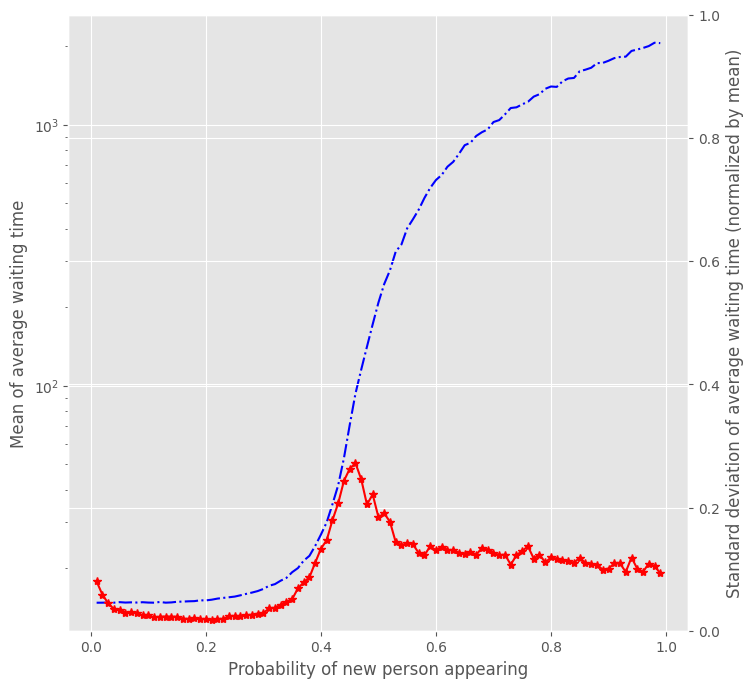

In [42]:
with plt.style.context('ggplot'):
    plt.figure(figsize=[8,8])
    plt.plot(ps, ms, "b-.")
    plt.yscale('log')
    plt.ylabel("Mean of average waiting time")
    plt.xlabel("Probability of new person appearing")
    plt.twinx()
    plt.plot(ps, vs, "r-*")
    plt.ylim(0, 1)
    plt.ylabel("Standard deviation of average waiting time (normalized by mean)")
    plt.show()

From the graph we see something strange happens somewhere p~0.42. The mean average time stays pretty much constant till that point, but afterwards shoots up abruptly. Those familiar with [Ising model](https://en.wikipedia.org/wiki/Ising_model) might recognize these graphs, and they are an indication of some sort of `phase transition`. In the case where p<0.4, person spawn rate is low enough that our elevator is able to clear the lounge. When p>0.4 though, elevator cannot keep up and lounge gets cluttered continuosly. The deviation of the average time also has a maxima around the same point. 

## Final remarks

These preliminary results are interesting, nevertheless more experimentation will be needed to understand full nature of the system. Firstly, does changing building size (number of floors) affect the results? how about max capacity of the elevator? Moreoever, protocol used here is pretty dumb, it just picks everyone on each floor, what if we just pick the people who are headed in the direction we are currently moving (for example, there are two people on floor 2, one going to floor 5, other going to floor 1, on our way down we only pick the second person). The people spawning routine is also very unrealistic, in most building people extensively travel between ground floor and the rest of the building rather than to travel between any two floors. 

It would be interesting how each of the factors affect the average waiting time for the elevator and phase transition point (value p at which there are immediate changes). 

To more efficient elevators for the advancement of humankind (certainly it is the only thing holding us back)!

<link rel="stylesheet" href="../../style.css">